### **Problem #2**

*   Apply only **logistic regression** for the **Ekush** dataset and build a binary classification model that can predict  **male/female** from Bengali handwritten digits with different hyperparameter settings.  

###What is Ekush?

Ekush: A Multipurpose and Multitype Comprehensive Database for Online Off-line Bangla Handwritten Characters. Ekush has several features:

* Characters Recognition
* Recognition in context
* Gender Identification
* Forensic Investigation 
* 673,482‬ character instances
* 242 character class
* 4 captions per image
* 340,243‬ Female data
* 333,239‬ Male data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

####As the female written digit are between 110 to 119 so I apply rename for these folders (110-119) because in the every folder the image names are same.This is applied for both male and female. Also I copy the images from folder (110-119) in allfemale folder and allmale folder both for female and male.

In [ ]:

path_folder='/content/gdrive/My Drive/Ekush/female'

src = path_folder+"/110" #111,112,113,114,115,116,117,118,119
dir_folders = os.listdir(src)
for dir_name in dir_folders:
    a='zero'+dir_name #zero,one,two,three,four,five,six,seven,eight,nine
    os.rename(src+ "/" +dir_name, src+ "/" +a)


In [ ]:
#Female digit images folder 110-119 coppied to allfemale folder

path_folder='/content/gdrive/My Drive/Ekush/female'

for i in range(0,10,1):
    src = path_folder+"/11"+str(i)
    path = '/content/gdrive/My Drive/Ekush/allfemale'
    dir_folders = os.listdir(src)
    for dir_name in dir_folders:
        file_name = os.path.join(src, dir_name)
        if os.path.isfile(file_name):
            shutil.copy(file_name, path)


In [ ]:
path_folder='/content/gdrive/My Drive/Ekush/male'

src = path_folder+"/110" #111,112,113,114,115,116,117,118,119
dir_folders = os.listdir(src)
for dir_name in dir_folders:
    a='zero'+dir_name #zero,one,two,three,four,five,six,seven,eight,nine
    os.rename(src+ "/" +dir_name, src+ "/" +a)

In [ ]:
#Male digit images folder 110-119 coppied to allmale folder

path_folder='/content/gdrive/My Drive/Ekush/male'

for i in range(0,10,1):
    src = path_folder+"/11"+str(i)
    path = '/content/gdrive/My Drive/Ekush/allmale'
    dir_folders = os.listdir(src)
    for dir_name in dir_folders:
        file_name = os.path.join(src, dir_name)
        if os.path.isfile(file_name):
            shutil.copy(file_name, path)

####Here I made two csv file for allmale and allfemale.For male I use 0 for labeling and for allfemale I use 1.

In [ ]:
a=os.listdir('/content/gdrive/My Drive/Ekush/allmale')
df = pd.DataFrame(data={"digit": 0, "filename": a})
df.to_csv("/content/gdrive/My Drive/Ekush/allmale.csv", sep=',',index=False)

In [ ]:
a=os.listdir('/content/gdrive/My Drive/Ekush/allfemale')
df = pd.DataFrame(data={"digit": 1, "filename": a})
df.to_csv("/content/gdrive/My Drive/Ekush/allfemale.csv", sep=',',index=False)

In [ ]:
PATH = '/content/gdrive/My Drive/Ekush/'
os.listdir(PATH)

['allfemale',
 'allfemale.csv',
 'allmale',
 'allmale.csv',
 'ekushCSV',
 'female',
 'female.zip',
 'male',
 'male.zip',
 'train']

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('allmale.csv')
b_csv = showRawTrainingSamples('allfemale.csv')

allmale.csv
Index(['digit', 'filename'], dtype='object')
allfemale.csv
Index(['digit', 'filename'], dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:2, :])   
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)
b_csv = dropColumns(b_csv)

                          filename  digit
0          eight0_18_kis_2_361.jpg      0
1      eight0_B.BARIA_14_1_362.jpg      0
2      eight0_B.BARIA_17_2_363.jpg      0
3        eight0_B.BARIA_20_3_1.jpg      0
4      eight0_B.BARIA_20_3_364.jpg      0
...                            ...    ...
15063     zero_0_THAK_20_3_345.jpg      0
15064     zero_0_THAK_20_3_346.jpg      0
15065     zero_0_THAK_21_3_347.jpg      0
15066     zero_0_THAK_21_3_348.jpg      0
15067     zero_0_THAK_22_3_349.jpg      0

[15068 rows x 2 columns]
                      filename  digit
0      eight0_18_kis_2_361.jpg      0
1  eight0_B.BARIA_14_1_362.jpg      0
                          filename  digit
0          eight1_14_BOG_1_317.jpg      1
1        eight1_22_Farid_3_318.jpg      1
2      eight1_B.BARIA_11_1_319.jpg      1
3      eight1_B.BARIA_11_1_320.jpg      1
4      eight1_B.BARIA_11_1_321.jpg      1
...                            ...    ...
15615      zero_1_TAN_1_1_1577.jpg      1
15616       zero_1_T

In [ ]:
#here i merge the two csv file
total_csv = [a_csv, b_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

30688


####Here I make a directory named train for copying all the images from male and female.

In [ ]:
TRAIN_PATH = '/content/gdrive/My Drive/Ekush/train'
os.mkdir(TRAIN_PATH)

In [ ]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
        shutil.copy(file_name, TRAIN_PATH)

In [ ]:
processImages('allmale')
print('Male Done')
processImages('allfemale')
print('Female Done')

Male Done
Female Done


####Here I resize the images in 28*28 that means 784 shape for train.

In [ ]:
path_folder='/content/gdrive/My Drive/Ekush/train'

src = path_folder
dir_folders = os.listdir(src)
for img_name in dir_folders:
    image = Image.open(path_folder+'/'+img_name)
    new_image = image.resize((28, 28))
    new_image.save(path_folder+'/'+img_name)

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  30688


In [ ]:
#hyperparameter settings 1
#here i take batch size 100,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.001 and number of epochs 15.

batch_size = 100
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:277
Test dataloader:31


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = torch.sigmoid(logits)
        return logits, probas
        #return logits

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6998015642166138. Accuracy: 55.60625814863103
Iteration: 1000. Loss: 0.6687878966331482. Accuracy: 56.02998696219035
Iteration: 1500. Loss: 0.6800397634506226. Accuracy: 57.69230769230769
Iteration: 2000. Loss: 0.6421768069267273. Accuracy: 56.61668839634941
Iteration: 2500. Loss: 0.6570056080818176. Accuracy: 54.95436766623207
Iteration: 3000. Loss: 0.7052382826805115. Accuracy: 56.84485006518905
Iteration: 3500. Loss: 0.6928590536117554. Accuracy: 56.551499348109516
Iteration: 4000. Loss: 0.6520233750343323. Accuracy: 55.63885267275098


In [ ]:
#settings 1
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model1.pkl') 

[0.6998015642166138, 0.6687878966331482, 0.6800397634506226, 0.6421768069267273, 0.6570056080818176, 0.7052382826805115, 0.6928590536117554, 0.6520233750343323]


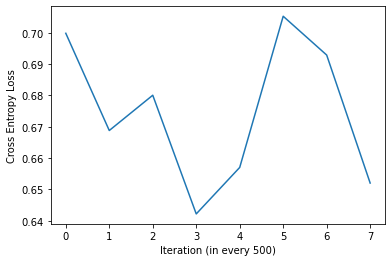

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 1
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)


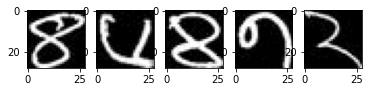

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 0 1 1 1]


In [ ]:
#hyperparameter settings 2
#here i take batch size 200,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.001 and number of epochs 15.
batch_size = 200
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:139
Test dataloader:16


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6691216230392456. Accuracy: 59.61538461538461
Iteration: 1000. Loss: 0.6924338340759277. Accuracy: 56.29074315514993
Iteration: 1500. Loss: 0.6561926007270813. Accuracy: 58.2464146023468
Iteration: 2000. Loss: 0.639789342880249. Accuracy: 59.55019556714472


In [ ]:
#settings 2
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model2.pkl') 

[0.6691216230392456, 0.6924338340759277, 0.6561926007270813, 0.639789342880249]


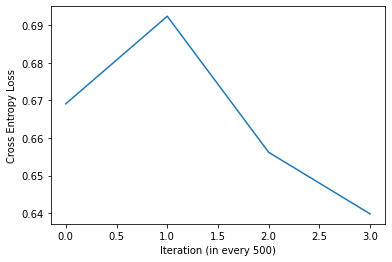

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 2
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model2.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


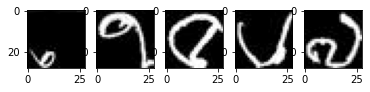

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 0 0 0 1]


In [ ]:
#hyperparameter settings 3
#here i take batch size 256,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.001 and number of epochs 15.
batch_size = 256
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:108
Test dataloader:12


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6682255268096924. Accuracy: 57.920469361147326
Iteration: 1000. Loss: 0.6754443645477295. Accuracy: 58.279009126466754
Iteration: 1500. Loss: 0.6659351587295532. Accuracy: 57.88787483702738


In [ ]:
#settings 3
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model3.pkl') 

[0.6682255268096924, 0.6754443645477295, 0.6659351587295532]


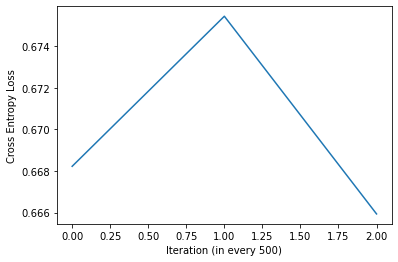

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 3
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model3.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)


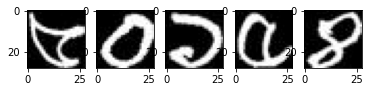

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [1 0 1 1 0]


In [ ]:
#hyperparameter settings 4
#here i take batch size 100,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.0001 and number of epochs 15.
batch_size = 256
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.0001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:108
Test dataloader:12


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6754642724990845. Accuracy: 56.747066492829205
Iteration: 1000. Loss: 0.6489248871803284. Accuracy: 58.116036505867015
Iteration: 1500. Loss: 0.6678870916366577. Accuracy: 58.18122555410691


In [ ]:
#settings 4
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model4.pkl') 

[0.6754642724990845, 0.6489248871803284, 0.6678870916366577]


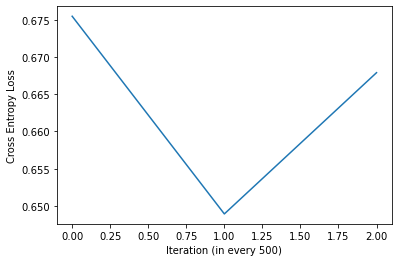

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 4
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model4.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)


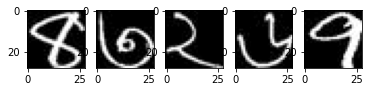

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [1 1 0 0 0]


In [ ]:
#hyperparameter settings 5
#here i take batch size 300,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.0001 and number of epochs 15.
batch_size = 300
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.0001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:93
Test dataloader:11


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6578286290168762. Accuracy: 58.57235984354629
Iteration: 1000. Loss: 0.6593379974365234. Accuracy: 58.833116036505864


In [ ]:
#settings 5
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model5.pkl') 

[0.6578286290168762, 0.6593379974365234]


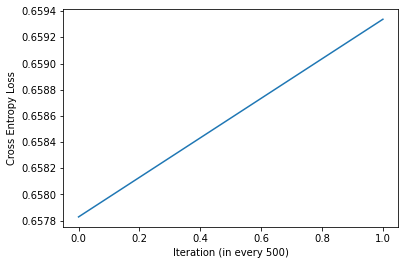

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 5
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model5.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


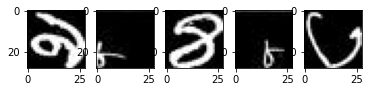

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [1 0 0 0 1]


In [ ]:
#hyperparameter settings 6
#here i take batch size 300,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.005 and number of epochs 15.
batch_size = 300
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.005

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:93
Test dataloader:11


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7362013459205627. Accuracy: 57.85528031290743
Iteration: 1000. Loss: 0.7108064889907837. Accuracy: 54.43285528031291


In [ ]:
#settings 6
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model6.pkl') 

[0.7362013459205627, 0.7108064889907837]


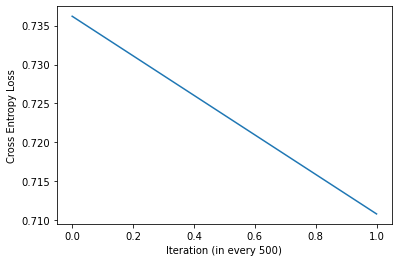

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 6
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model6.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)


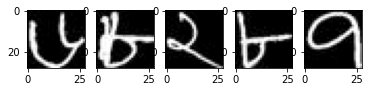

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 1 1 1 1]


In [ ]:
#hyperparameter settings 7
#here i take batch size 200,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.004 and number of epochs 15.
batch_size = 200
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.004

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:139
Test dataloader:16


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7225029468536377. Accuracy: 55.08474576271186
Iteration: 1000. Loss: 0.7387209534645081. Accuracy: 57.00782268578879
Iteration: 1500. Loss: 0.732646107673645. Accuracy: 57.69230769230769
Iteration: 2000. Loss: 0.6848976612091064. Accuracy: 59.0612777053455


In [ ]:
#settings 7
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model7.pkl') 

[0.7225029468536377, 0.7387209534645081, 0.732646107673645, 0.6848976612091064]


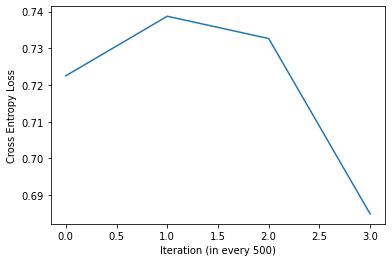

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 7
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model7.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)


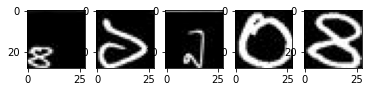

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [1 1 0 1 1]


In [ ]:
#hyperparameter settings 8
#here i take batch size 200,number of iteration 1000,input dimension 28*28,output dimension 2 as this is a binary clasification,learning rate 0.005 and number of epochs 15.
batch_size = 200
num_iters = 1000
input_dim = 28*28 # num_features = 784
output_dim = 2
num_epochs = int(15)
learning_rate = 0.005

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

3068
Train dataloader:139
Test dataloader:16


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7637618184089661. Accuracy: 56.551499348109516
Iteration: 1000. Loss: 0.7097329497337341. Accuracy: 55.997392438070406
Iteration: 1500. Loss: 0.6715256571769714. Accuracy: 56.160365058670145
Iteration: 2000. Loss: 0.7061070799827576. Accuracy: 56.32333767926988


In [ ]:
#settings 8
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'model8.pkl') 

[0.7637618184089661, 0.7097329497337341, 0.6715256571769714, 0.7061070799827576]


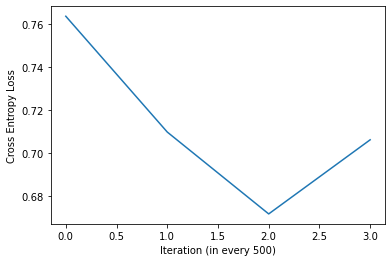

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
#settings 8
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'model8.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)


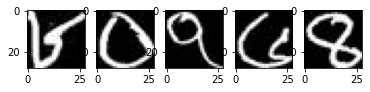

In [ ]:
for images, labels in test_loader:
   break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
    print(labels[i])

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 1 0 0 1]


Here I take num_iteration 1000 for all the settings and input dimention 28*28 = 784 with output dimention 2.

**Settings Table:-**

| Settings| Batch Size      | Learning Rate |  Optimzer           |  Accuracy(%)|
|:--------:| :----------: | : -----------:|:-----:      |:-----------:|
| 1        | 100          | 0.001        |  ADAM    |  55.63    |
| 2        | 200          | 0.001        |  ADAM    |  59.55  |
| 3        | 256          | 0.001        |  ADAM   |  57.88     |
| 4        | 256          | 0.0001        |  ADAM   |  58.18     |
| 5        | 300          | 0.0001         |  ADAM    |  58.83     |
| 6        | 300          | 0.005         |  ADAM    |  54.43     |
| 7        | 200          | 0.004         |  ADAM    |  59.06     |
| 8        | 200          | 0.005         |  ADAM    |  56.32     |

From the table it can be seen that I got the highst accuracy for the Ekush dataset is 59.55 for the setting 2.


Here I Show the loss curve for setting 8 to 1 respectively.





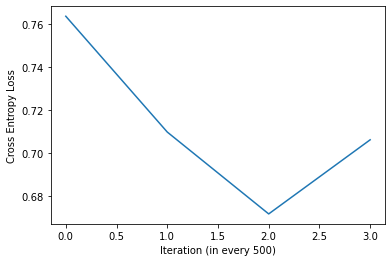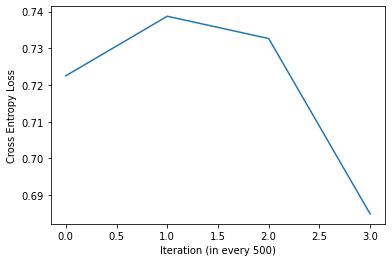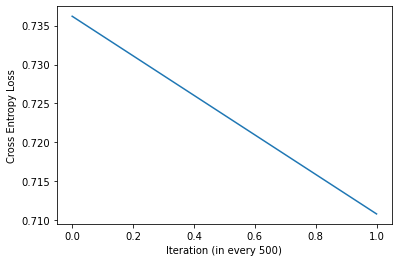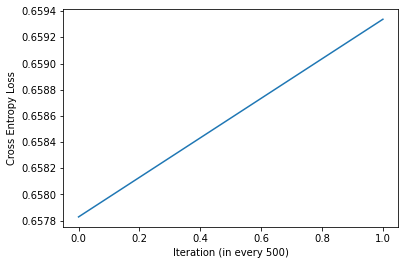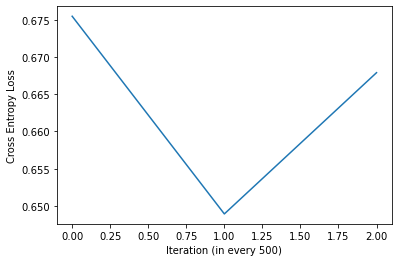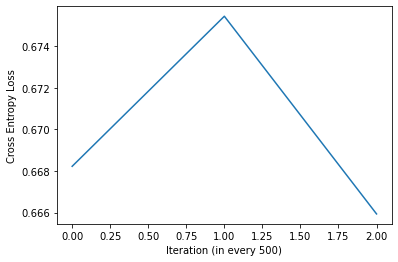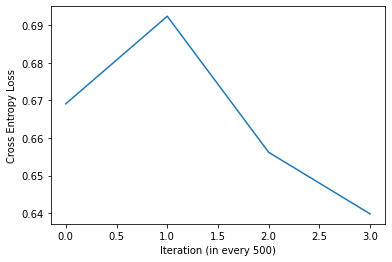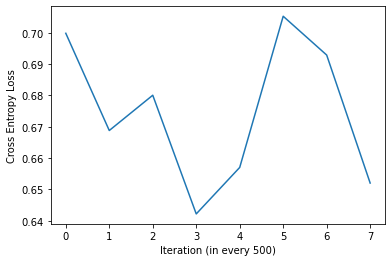